In [1]:
import os
from pathlib import Path
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.datasets import somato
import mne_bids
from mne_connectivity import spectral_connectivity
#import mne_connectivity

import pandas as pd
import scipy.signal as sig
import scipy.stats as stats
from scipy.special import softmax
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from skimage import measure
import pickle

In [38]:
%%capture
# Prevents prints from occuring for ease of reading code (can be removed)

data = pd.read_csv('jhu_new_patients.csv', index_col = 0)

# sets the path for files
root = Path('/Users/silumen/OneDrive - Johns Hopkins/Documents/40Hz-30/')

bad_subs = []

# loops thru each of the subjects
for index, row in data.iterrows():
    # formats the fields needed for mne_bids to the correct length
    subject = '{:03d}'.format(row['id'])
    session = row['session']
    task = row['task']
    run = '{:02d}'.format(row['run'])
    acq = 'run'
    datatype = 'eeg'
    # reads in data
    bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task,
                     acquisition=None, run=run, datatype=datatype, root=root,
                     suffix='eeg', extension='.vhdr')
    raw = mne_bids.read_raw_bids(bids_path)
    
    # ensures all windows are 30 seconds
    sfreq = raw.info['sfreq']
    win_size = int(sfreq*30)
    
    # gets the channel names
    cols = np.array(raw.info['ch_names'])
    
    # sets the new dataframe of the raw data to be processed
    df = raw.to_data_frame()
    df = df.set_index('time')
    
    # keeps all channels except midline (since they may be unplugged)
    idx = []
    for i, col in enumerate(cols):
        if 'Z' in col:
            idx.append(i)
            df = df.drop([col], axis = 1)
    cols = np.delete(cols, idx)
    
    # converts raw data to numpy array
    df_array = np.array(df)
    
    if df_array.shape[1] != 16:
        bad_subs.append(subject)
        continue
    
    df_array = df_array[:int(sfreq*30*10), :]
    
    
    # finds the correct number of chunks to split into
    chunks = int(np.ceil(df_array.shape[0] / win_size))
    
    split_30_s = np.split(df_array, chunks, axis = 0)
    split_30_arr = np.zeros((len(split_30_s), split_30_s[0].shape[1], split_30_s[0].shape[0]))
    
    
    for i in range(len(split_30_s)):
        split_30_arr[i, :, :] = split_30_s[i].transpose()     
              
    
    for method in ['coh', 'cohy', 'imcoh']:
        
        time_conn = np.zeros((split_30_arr.shape[0], split_30_arr.shape[1], split_30_arr.shape[1]))
        
        for i, time in enumerate(split_30_arr):
            time = time[np.newaxis, :, :]
            
            conn = spectral_connectivity(time, method=method, sfreq = sfreq)
            
            conn = np.mean(conn[0], axis = 2)
            conn += np.rot90(np.fliplr(conn)) + np.eye(conn.shape[0])
            
            time_conn[i] = conn
        
        # creates directory for numpy files and for figures
        if not os.path.exists(os.path.join(root, 'derivatives/{}/'.format(method))):
            os.makedirs(os.path.join(root, 'derivatives/{}/'.format(method)))
        meas_path = os.path.join(root, 'derivatives/{}/'.format(method))

        if not os.path.exists(os.path.join(root, 'derivatives/figures/{}/'.format(method))):
            os.makedirs(os.path.join(root, 'derivatives/figures/{}/'.format(method)))
        figures_path = os.path.join(root, 'derivatives/figures/{}/'.format(method))

        # creates path for numpy data to be stored
        if not os.path.exists(os.path.join(meas_path, 'sub-{}'.format(subject))):
            os.makedirs(os.path.join(meas_path, 'sub-{}'.format(subject)))

        folder = os.path.join(meas_path, 'sub-{}'.format(subject))

        base = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
        base = os.path.join(folder, base)

        np.save(base + '30-s-split.npy', time_conn)
    
        # changes the order of the columns so all odds are next to each other
        # and all evens are next to each other
        odd = list(range(1, len(cols), 2))
        even = list(range(0, len(cols), 2))
        new = even + odd
        cols = cols[new]

        # makes path for figures
        if not os.path.exists(os.path.join(figures_path, 'sub-{}'.format(subject))):
            os.makedirs(os.path.join(figures_path, 'sub-{}'.format(subject)))

        direc = os.path.join(figures_path, 'sub-{}'.format(subject))

        filen = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
        filen = os.path.join(direc, filen)

        # gets the mean plv value and plots it
        mean = np.mean(time_conn, axis = 0)
        mean = mean[new, :]
        mean = mean[:, new]

        sbs.heatmap(data=mean, vmin = 0, vmax = 1, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
        plt.savefig(filen + '30-s-split-mean.png')
        plt.close()

        # gets the standard deviation of the plv values and plots it
        std = np.std(time_conn, axis = 0)
        std = std[new, :]
        std = std[:, new]

        sbs.heatmap(data = std, vmin = 0, vmax = 0.3, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
        plt.savefig(filen + '30-s-split-std.png')
        plt.close()

        # plots the plv values for each of the windows
        for i in range(time_conn.shape[0]):
            window = time_conn[i, :, :]
            window = window[new, :]
            window = window[:, new]

            sbs.heatmap(data = window, vmin = 0, vmax = 1, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
            plt.savefig(filen + 'split-{}-{}.png'.format(time_conn.shape[0], i+1))
            plt.close()

ValueError: array split does not result in an equal division

In [46]:
test = np.load('/Users/silumen/OneDrive - Johns Hopkins/Documents/40Hz-30/derivatives/plv/sub-021/sub-021_ses-initialvisit_task-monitor_run-01_desc-30-s-split.npy')

<AxesSubplot:>

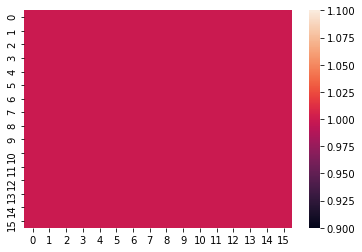

In [47]:
sbs.heatmap(test[0])

In [48]:
test[0]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [54]:
np.max(conn[1]), np.min(conn[1]), conn[2][-1], conn[3], conn[4]

(100.0, 0.16666666666666666, 29.995, 10, None)

In [74]:
len(conn), conn[0].shape, conn[1].shape, conn[2].shape, conn[3], conn[4]

(5, (16, 16, 2996), (2996,), (6000,), 10, None)

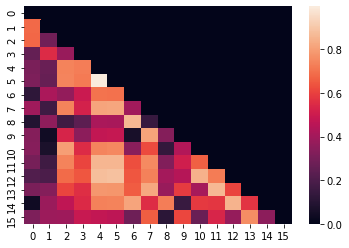

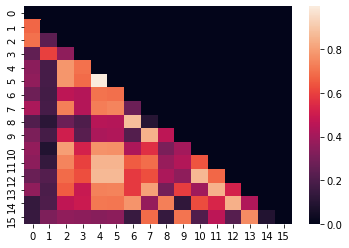

In [69]:
sbs.heatmap(conn[0][:, :, 2])
plt.show()
sbs.heatmap(conn[0][:, :, 3])
plt.show()